In [47]:
# Import necessary modules
import glob
import json
import numpy as np
import math
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import subprocess
import sys

from datetime import datetime, timedelta
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle, Circle
from mpl_toolkits.mplot3d import Axes3D

In [48]:
# Import custom modules
sys.path.insert(1, '../io/inputs/')
from constants import *

sys.path.insert(1, '../core/')
from nsrdb import data_download
from solar_position import *

In [49]:
# Plotting settings
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'Computer Modern Roman',
})

In [50]:
# Key files and file paths
nsrdb_file_path         = '../io/inputs/nsrdb/'
nsrdb_data_file_pattern = r'nsrdb_(.*?)_\d+\.csv'  

key_region_file         = '../io/inputs/key_region_dict.json'
key_crop_file           = '../io/inputs/key_crop_dict.json'
key_crop_style_file     = '../io/inputs/key_crop_styles.json'

csv_output_directory    = '../io/outputs/csv_crop_growth/'
plots_output_directory  = '../io/outputs/plots_crop_growth/'
video_output_directory  = '../io/outputs/videos_crop_growth/'

In [51]:
# Key region dictionary
with open(key_region_file, 'r') as json_file:
    key_region_dict = json.load(json_file)

API_KEY = 'cZmm6xKmZ08RHq8bk4vNnaFlXAqyj5mMrUUWteS6'
EMAIL = 'carlabecker@berkeley.edu'
BASE_URL = "https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-2-2-tmy-download.json?"
POINTS = []
for key, value in key_region_dict.items():
    POINT = value['nsrdb_code']
    POINTS.append(POINT)

# Key crop dictionary
with open(key_crop_file, 'r') as json_file:
    key_crop_dict = json.load(json_file)

# Key crop styles dictionary
with open(key_crop_style_file, 'r') as json_file:
    key_crop_styles_dict = json.load(json_file)

In [52]:
# User Input
region     = "iowa"
make_video = False

start_year   = 2024 # year in which the simulation starts   [unitless, in {1, 2024}]
start_month  = 5    # month in which the simulation starts  [unitless, in {1, 12}]
start_day    = 31   # day on which the simulation starts    [unitless, in {1, 31}]
start_hour   = 12   # hour in which the simulation starts   [unitless, in {1, 24}]
start_minute = 0    # minute in which the simulation starts [unitless, in {1, 60}]
start_second = 0    # second at which the simulation starts [unitless, in {1, 60}]

end_year     = 2024 # year in which the simulation ends     [unitless, in {1, 2024}]
end_month    = 9    # month in which the simulation ends    [unitless, in {1, 12}]
end_day      = 30   # day on which the simulation ends      [unitless, in {1, 31}]
end_hour     = 12   # hour in which the simulation ends     [unitless, in {1, 24}]
end_minute   = 0    # minute in which the simulation ends   [unitless, in {1, 60}]
end_second   = 0    # second at which the simulation ends   [unitless, in {1, 60}]

water_start_hour      = 9  # hour of the day when plants get watered    [unitless, in {1, 24}]
fertilizer_start_hour = 15 # hour of the day when plants get fertilized [unitless, in {1, 24}]

water_frequency      = 1  # plants are watered every x days    [days, in {0, 365}]
fertilizer_frequency = 30 # plants are fertilized every x days [days, in {0, 365}]

water_amount_per_plant      = 0.2 # amount of water delivered to each plant each time it is watered         [kg] 
fertilizer_amount_per_plant = 0.2 # amount of fertilizer delivered to each plant each time it is fertilized [kg] 

water_start_year   = start_year           # year in which the first watering occurs   [unitless, in {1, 2024}]
water_start_month  = 5                    # month in which the first watering occurs  [unitless, in {1, 12}]
water_start_day    = 31                   # day on which the first watering occurs    [unitless, in {1, 31}]
water_start_hour   = water_start_hour     # hour in which the first watering occurs   [unitless, in {1, 24}]
water_start_minute = DEFAULT_START_MINUTE # minute in which the first watering occurs [unitless, in {1, 60}]
water_start_second = DEFAULT_START_SECOND # second at which the first watering occurs [unitless, in {1, 60}]

fertilizer_start_year   = start_year            # year in which the first fertilization occurs   [unitless, in {1, 2024}]
fertilizer_start_month  = 5                     # month in which the first fertilization occurs  [unitless, in {1, 12}]
fertilizer_start_day    = 31                    # day on which the first fertilization occurs    [unitless, in {1, 31}]
fertilizer_start_hour   = fertilizer_start_hour # hour in which the first fertilization occurs   [unitless, in {1, 24}]
fertilizer_start_minute = DEFAULT_START_MINUTE  # minute in which the first fertilization occurs [unitless, in {1, 60}]
fertilizer_start_second = DEFAULT_START_SECOND  # second at which the first fertilization occurs [unitless, in {1, 60}]

# Store date/time input
start_date = datetime(year=start_year, 
                      month=start_month, 
                      day=start_day, 
                      hour=start_hour, 
                      minute=start_minute, 
                      second=start_second)
end_date = datetime(year=end_year,         
                    month=end_month,   
                    day=end_day,   
                    hour=end_hour,   
                    minute=end_minute,   
                    second=end_second)
water_start_date = datetime(year=water_start_year, 
                            month=water_start_month, 
                            day=water_start_day, 
                            hour=water_start_hour, 
                            minute=water_start_minute, 
                            second=water_start_second)
fertilizer_start_date = datetime(year=fertilizer_start_year, 
                                month=fertilizer_start_month, 
                                day=fertilizer_start_day, 
                                hour=fertilizer_start_hour, 
                                minute=fertilizer_start_minute, 
                                second=fertilizer_start_second)

In [53]:
# NSRDB data is 1 year of hourly data
# Extract the indices of start and end data points based on user input

def get_nsrdb_equiv_point(date_time):

    # Returns an integer that indicates the row index at which to start in the NSRDB dataset
    # January 1st is 0
    # December 31st is 8759
    equiv_point = 0
    for month in range(1, date_time.month):

        # If month is Jan, Mar, May, Jul, Aug, Oct, or Dec, add 31 * 24 points
        if month in [1, 3, 5, 7, 8, 10, 12]:
            equiv_point += 31 * HOURS_PER_DAY

        # If month is Apr, Jun, Sep, or Nov, add 30 * 24 points
        elif month in [4, 6, 9, 11]:
            equiv_point += 30 * HOURS_PER_DAY

        # If month is Feb, add 28 * 24 points
        else:
            equiv_point += 28 * HOURS_PER_DAY

    # Once the month loop has finished, add points for the days
    equiv_point = equiv_point + (date_time.day - 1) * HOURS_PER_DAY

    # Once points for the days have been added, add points for the hours
    equiv_point = equiv_point + date_time.hour

    return equiv_point

start_point = get_nsrdb_equiv_point(start_date)
end_point   = get_nsrdb_equiv_point(end_date)

In [54]:
# Get radiation data from NSDRB
# Already done, but uncomment below to freshly retrieve the data
# data_download(API_KEY, EMAIL, BASE_URL, POINTS)

# Load the pre-downloaded CSV data 
sys.path.insert(1, nsrdb_file_path)

# Regular expression pattern to match the region names
compiled_nsrdb_data_file_pattern = re.compile(nsrdb_data_file_pattern)

# Use glob to list files matching the initial pattern
for file_path in glob.glob(os.path.join(nsrdb_file_path, '*')):
    
    filename = os.path.basename(file_path)
    
    # Use regex to check if the filename matches the pattern
    match = compiled_nsrdb_data_file_pattern.match(filename)
    if match:

        # If it matches, extract the state name and use it as a dictionary key
        state = match.group(1)
        
        # Add the data as an attribute to the state in the dictionary
        nsrdb_data = pd.read_csv(file_path, header='infer')
        key_region_dict[state]['nsrdb_data'] = nsrdb_data

In [55]:
# Variable Glossary - Field Configuration
num_plants_x        = 17                              # number of plants in a row in the x-direction                [unitless]
num_plants_y        = 9                               # number of plants in a column in the y-direction             [unitless]
num_plants          = num_plants_x * num_plants_y     # number of plants in the field,                              [unitless]
crop                = key_region_dict[region]['crop'] # crop type                                                   [unitless]
field_dim_x         = 16                              # length of the field in the x-direction                      [m]
field_dim_y         = 8                               # width of the field in the y-direction                       [m]
field_azimuth_angle = 0                               # clockwise rotation of farm origin from north,               [degrees]
field_zenith_angle  = 0                               # surface normal of plane in which field lives w.r.t. z-axis, [degrees]  

In [56]:
# Variable Glossary - Simulation Settings
start_solar_position     = SolarPosition(key_region_dict, start_date, region)
end_solar_position       = SolarPosition(key_region_dict, end_date,   region)
total_simulation_days    = end_solar_position.get_number_day() - start_solar_position.get_number_day() # total simulation time in days,         [days]
time_step_size           = 1                                                                           # simulation time step size in hours,    [hours] 
area_leaf_test_point     = 0.005                                                                       # area of leaf test point,               [m2]
density_leaf_test_points = 1/area_leaf_test_point                                                      # density of test points within a leaf,  [points/m2]
num_time_steps_per_day   = int(np.ceil(HOURS_PER_DAY/time_step_size))                                  # number of time steps in one day,       [unitless]
total_time_steps         = total_simulation_days * num_time_steps_per_day                              # total number of simulation time steps, [unitless]

In [57]:
# Variable Glossary - Inital Conditions for Time-Dependent Variables
days_after_sowing       = 0                                # days after sowing,                                          [days]
height                  = 0.01 * np.ones(total_time_steps) # initial height of representative plant,                     [m]
leaf_area               = 1e-5 * np.ones(total_time_steps) # initial leaf area of representative plant,                  [m2]
irradiance_leaf_surface = 0.01 * np.ones(total_time_steps) # initial irradiance at leaf surface of representative plant, [W/m2]
canopy_biomass          = 0.01 * np.ones(total_time_steps) # initial canopy biomass of representative plant,             [kg]
fruit_biomass           = 0.01 * np.ones(total_time_steps) # initial fruit biomass of representative plant,              [kg]

In [58]:
# Variable Glossary - Growth Rates
growth_rate_canopy_biomass                = key_crop_dict[crop]['growth_rate_canopy_biomass'][0]                # [1/s]
growth_rate_fruit_biomass                 = key_crop_dict[crop]['growth_rate_fruit_biomass'][0]                 # [1/s]
growth_rate_height                        = key_crop_dict[crop]['growth_rate_height'][0]                        # [1/s]
growth_rate_height_fertilizer_specific    = key_crop_dict[crop]['growth_rate_height_fertilizer_specific'][0]    # [1/s]
growth_rate_height_water_specific         = key_crop_dict[crop]['growth_rate_height_water_specific'][0]         # [1/s]
growth_rate_leaf_area_fertilizer_specific = key_crop_dict[crop]['growth_rate_leaf_area_fertilizer_specific'][0] # [1/s]
growth_rate_leaf_area_temp_specific       = key_crop_dict[crop]['growth_rate_leaf_area_temp_specific'][0]       # [1/s]
growth_rate_leaf_area_water_specific      = key_crop_dict[crop]['growth_rate_leaf_area_water_specific'][0]      # [1/s]

In [59]:
# Variable Glossary - Peak Growth Times
scaling_factor_peak_growth_time_height_fertilizer_specific    = key_crop_dict[crop]['scaling_factor_peak_growth_time_height_fertilizer_specific'][0]    # [1/s]
scaling_factor_peak_growth_time_height_water_specific         = key_crop_dict[crop]['scaling_factor_peak_growth_time_height_water_specific'][0]         # [1/s]
scaling_factor_peak_growth_time_leaf_area_fertilizer_specific = key_crop_dict[crop]['scaling_factor_peak_growth_time_leaf_area_fertilizer_specific'][0] # [1/s]
scaling_factor_peak_growth_time_leaf_area_temp_specific       = key_crop_dict[crop]['scaling_factor_peak_growth_time_leaf_area_temp_specific'][0]       # [1/s]
scaling_factor_peak_growth_time_leaf_area_water_specific      = key_crop_dict[crop]['scaling_factor_peak_growth_time_leaf_area_water_specific'][0]      # [1/s]

In [60]:
# Variable Glossary - Other Peak Growth Parameters
scaling_factor_peak_height_growth_fertilizer_specific    = key_crop_dict[crop]['scaling_factor_peak_height_growth_fertilizer_specific'][0]    # [unitless]
scaling_factor_peak_height_growth_water_specific         = key_crop_dict[crop]['scaling_factor_peak_height_growth_water_specific'][0]         # [unitless]
scaling_factor_peak_leaf_area_growth_fertilizer_specific = key_crop_dict[crop]['scaling_factor_peak_leaf_area_growth_fertilizer_specific'][0] # [1/s]
scaling_factor_peak_leaf_area_growth_temp_specific       = key_crop_dict[crop]['scaling_factor_peak_leaf_area_growth_temp_specific'][0]       # [1/s]
scaling_factor_peak_leaf_area_growth_water_specific      = key_crop_dict[crop]['scaling_factor_peak_leaf_area_growth_water_specific'][0]      # [1/s]

In [61]:
# Variable Glossary - Decay Rates
decay_rate_canopy_biomass           = key_crop_dict[crop]['decay_rate_canopy_biomass'][0]           # [1/s]
decay_rate_fruit_biomass            = key_crop_dict[crop]['decay_rate_fruit_biomass'][0]            # [1/s]
decay_rate_height                   = key_crop_dict[crop]['decay_rate_height'][0]                   # [1/s]
decay_rate_leaf_area_temp_specific  = key_crop_dict[crop]['decay_rate_leaf_area_temp_specific'][0]  # [1/s/degC]
decay_rate_leaf_area_water_specific = key_crop_dict[crop]['decay_rate_leaf_area_water_specific'][0] # [1/kg]

In [62]:
# Variable Glossary - Carrying Capacities
carrying_capacity_canopy_biomass = key_crop_dict[crop]['carrying_capacity_canopy_biomass'][0] # [m2]
carrying_capacity_fruit_biomass  = key_crop_dict[crop]['carrying_capacity_fruit_biomass'][0]  # [kg]
carrying_capacity_height         = key_crop_dict[crop]['carrying_capacity_height'][0]         # [m]
carrying_capacity_leaf_area      = key_crop_dict[crop]['carrying_capacity_leaf_area'][0]      # [kg]

In [63]:
# Variable Glossary - Gains from Various Stimuli
gains_height_from_fertilizer    = key_crop_dict[crop]['gains_height_from_fertilizer'][0]    # [m/kg]
gains_height_from_water         = key_crop_dict[crop]['gains_height_from_water'][0]         # [m/kg]
gains_leaf_area_from_fertilizer = key_crop_dict[crop]['gains_leaf_area_from_fertilizer'][0] # [m2/kg]
gains_leaf_area_from_temp       = key_crop_dict[crop]['gains_leaf_area_from_temp'][0]       # [m2/degC]
gains_leaf_area_from_water      = key_crop_dict[crop]['gains_leaf_area_from_water'][0]      # [m2/kg]

In [64]:
# Variable Glossary - Thresholds for Growth/Decay
threshold_canopy_fruit_growth     = key_crop_dict[crop]['threshold_canopy_fruit_growth'][0]     # [kg]
threshold_height_leaf_growth      = key_crop_dict[crop]['threshold_height_leaf_growth'][0]      # [m]
threshold_dAdt_canopy_fruit_decay = key_crop_dict[crop]['threshold_dAdt_canopy_fruit_decay'][0] # [m2/s]

In [65]:
# Variable Glossary - Other Crop-specific Parameters
absorption_factor_single_leaf            = key_crop_dict[crop]['absorption_factor_single_leaf'][0]            # [unitless]
conal_angle_leaves_wrt_stem              = key_crop_dict[crop]['conal_angle_leaves_wrt_stem'][0]              # [degrees]
efficiency_coefficient_photosynthesis    = key_crop_dict[crop]['efficiency_coefficient_photosynthesis'][0]    # [1/W]
fruit_biomass_temp_sensitivity_parameter = key_crop_dict[crop]['fruit_biomass_temp_sensitivity_parameter'][0] # [unitless]
typical_canopy_density                   = key_crop_dict[crop]['typical_canopy_density'][0]                   # [kg/m3]

In [66]:
# Variable Glossary - Hourly Temperature
temp_ceiling_fruit_growth  = key_crop_dict[crop]['temp_ceiling_fruit_growth'][0]  # [degC]
temp_critical_fruit_growth = key_crop_dict[crop]['temp_critical_fruit_growth'][0] # [degC]
temp_optimal_fruit_growth  = key_crop_dict[crop]['temp_optimal_fruit_growth'][0]  # [degC]

all_hourly_temperatures = key_region_dict[region]['nsrdb_data']['Temperature']
hourly_temperatures = np.array(all_hourly_temperatures[start_point:end_point])

In [67]:
# Variable Glossary - Hourly Radiation
all_hourly_radiation = key_region_dict[region]['nsrdb_data']['GHI'] + \
                       key_region_dict[region]['nsrdb_data']['DNI'] + \
                       key_region_dict[region]['nsrdb_data']['DHI']
hourly_radiation = np.array(all_hourly_radiation[start_point:end_point])

In [68]:
# Export hourly radiation and temperature data to CSV
hourly_rad_temp = np.column_stack((hourly_radiation, hourly_temperatures))
np.savetxt(f"hourly_rad_temp_{region}.csv", hourly_rad_temp, delimiter=",", fmt="%.6f")

In [69]:
# Variable Glossary - Hourly Water Consumption
water_ceiling_fruit_growth       = key_crop_dict[crop]['water_ceiling_fruit_growth'][0]       # [kg]
water_critical_fruit_growth      = key_crop_dict[crop]['water_critical_fruit_growth'][0]      # [kg]
water_optimal_fruit_growth       = key_crop_dict[crop]['water_optimal_fruit_growth'][0]       # [kg"]

all_hourly_water_consumption = np.zeros(all_hourly_temperatures.shape)
water_start_point = get_nsrdb_equiv_point(water_start_date)
water_point_frequency = water_frequency * HOURS_PER_DAY # convert frequency from every x days to every y hours

for point in range(water_start_point, end_point, water_point_frequency):
    all_hourly_water_consumption[point] = water_amount_per_plant

# Trim all hourly water consumption to obtain hourly water consumption for target growing period
hourly_water_consumption = np.array(all_hourly_water_consumption[start_point:end_point])

In [70]:
# Variable Glossary - Hourly Fertilizer Consumption
fertilizer_critical_fruit_growth = key_crop_dict[crop]['fertilizer_critical_fruit_growth'][0] # [kg]

all_hourly_fertilizer_consumption = np.zeros(all_hourly_temperatures.shape)
fertilizer_start_point = get_nsrdb_equiv_point(fertilizer_start_date)
fertilizer_point_frequency = fertilizer_frequency * HOURS_PER_DAY # convert frequency from every x days to every y hours

for point in range(fertilizer_start_point, end_point, fertilizer_point_frequency):
    all_hourly_fertilizer_consumption[point] = fertilizer_amount_per_plant

# Trim all hourly water consumption to obtain hourly water consumption for target growing period
hourly_fertilizer_consumption = np.array(all_hourly_fertilizer_consumption[start_point:end_point])

In [71]:
# Save to CSV for later reference
stacked_hourly_data = np.vstack((hourly_temperatures, hourly_water_consumption, hourly_fertilizer_consumption))

# Transpose the stacked array to get shape (end_point-start_point, 3)
transposed_hourly_data = stacked_hourly_data.T

# Create a DataFrame with the transposed data
hourly_df = pd.DataFrame(transposed_hourly_data, columns=['Hourly Temperatures', 'Hourly Water Consumption', 'Hourly Fertilizer Consumption'])

# Save the DataFrame to a CSV file
hourly_df.to_csv('hourly_temp_water_fertilizer.csv', index=False)

In [72]:
# Modify the crop name for use in plot titles
if crop.endswith('s'):
    crop_for_title = crop[:-1]
else:
    crop_for_title = crop
crop_for_title = crop_for_title.capitalize()

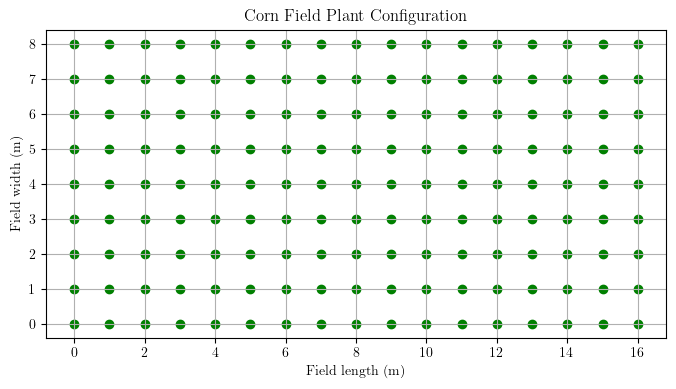

In [73]:
# Set the (x, y) coordinates of the plants

def generate_2d_plant_coordinates(num_plants_x, num_plants_y, field_dim_x, field_dim_y):

    # Calculate spacing between points
    spacing_x = field_dim_x / (num_plants_x - 1)
    spacing_y = field_dim_y / (num_plants_y - 1)
    
    # Generate coordinates
    coordinates_list_of_tuples = []
    coords_3d_col_row_xy = np.zeros((num_plants_x, num_plants_y, 2))
    for i in range(num_plants_x):
        x = i * spacing_x
        for j in range(num_plants_y):
            y = j * spacing_y
            coords_3d_col_row_xy[i, j] = np.array((x, y))
            coordinates_list_of_tuples.append((x, y))
    
    return coordinates_list_of_tuples, coords_3d_col_row_xy

def plot_2d_plant_coordinates(coordinates_list_of_tuples, plant_config_filename):

    # Unpack the coordinates into separate x and y lists
    x_coords, y_coords = zip(*coordinates_list_of_tuples)
    
    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.scatter(x_coords, y_coords, color='green')
    plt.xlabel('Field length (m)')
    plt.ylabel('Field width (m)')
    title = f'{crop_for_title} Field Plant Configuration'
    plt.title(title)
    plt.grid(True)
    plt.savefig(plant_config_filename, format='png')
    plt.show()

# Plot the locations of the plants in the field
coordinates_list_of_tuples, coords_3d_col_row_xy = generate_2d_plant_coordinates(num_plants_x, num_plants_y, field_dim_x, field_dim_y)
plant_config_filename = f'{plots_output_directory}/{crop}_plant_configuration.png'
plot_2d_plant_coordinates(coordinates_list_of_tuples, plant_config_filename)

# Test that reshaping works as expected
coords_2d_plant_xy = coords_3d_col_row_xy.reshape(num_plants_x * num_plants_y, 2)
xcoords_canopy = coords_2d_plant_xy[:, 0]
ycoords_canopy = coords_2d_plant_xy[:, 1]

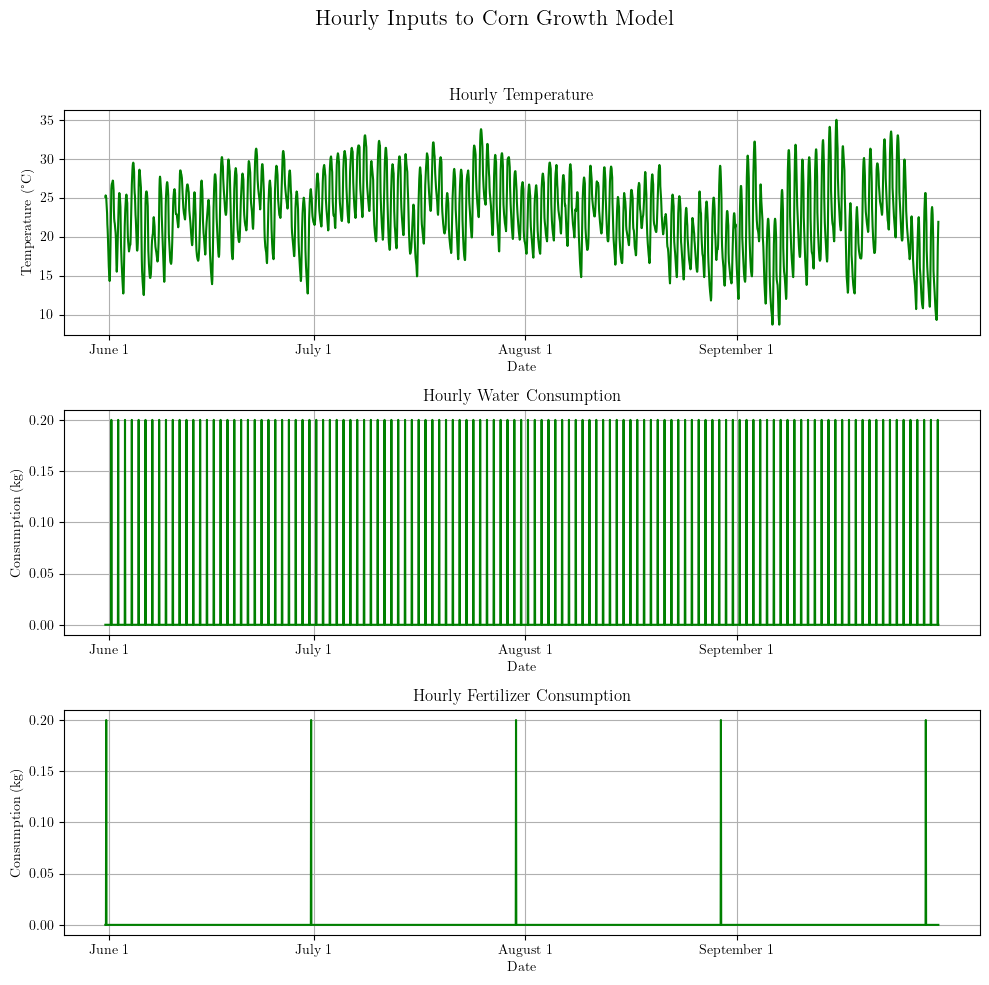

In [74]:
# Helper functions for plotting input data
def get_hourly_data_labels(start_point, end_point):
    hourly_date_labels_points = []
    hourly_date_labels_labels = []
    for month in range(1, MONTHS_PER_YEAR):
        this_year   = start_year 
        this_month  = month    
        this_day    = 1   
        this_hour   = 0   
        this_minute = 0   
        this_second = 0   
        this_date = datetime(year=this_year, 
                            month=this_month, 
                            day=this_day, 
                            hour=this_hour, 
                            minute=this_minute, 
                            second=this_second)
        date_labels_point = get_nsrdb_equiv_point(this_date)
        if date_labels_point >= start_point and date_labels_point <= end_point:
            hourly_date_labels_points.append(date_labels_point)
            hourly_date_labels_labels.append(f'{this_date.strftime('%B')} {this_date.day}')
    return hourly_date_labels_points, hourly_date_labels_labels

def get_daily_data_labels(start_point, end_point):
    hourly_date_labels_points, hourly_date_labels_labels = get_hourly_data_labels(start_point, end_point)
    daily_date_labels_points = [point/HOURS_PER_DAY for point in hourly_date_labels_points]
    daily_date_labels_labels = hourly_date_labels_labels
    return daily_date_labels_points, daily_date_labels_labels

def plot_consumption(consumption, start_point, end_point, consumption_frequency, ax, title, ylabel):
    consumption = consumption.flatten()
    xlabel = 'Date'

    if consumption_frequency == 'hourly':
        date_labels_points, date_labels_labels = get_hourly_data_labels(start_point, end_point)
        ax.plot(range(start_point, end_point), consumption, color='green')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(ticks=date_labels_points)
        ax.set_xticklabels(labels=date_labels_labels, rotation=0)
        ax.grid(True)
    elif consumption_frequency == 'daily':
        date_labels_points, date_labels_labels = get_daily_data_labels(start_point, end_point)
        start_point = int(np.floor(start_point / HOURS_PER_DAY))
        end_point = int(np.floor(end_point / HOURS_PER_DAY))
        ax.plot(range(start_point, end_point), consumption, color='green')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(ticks=date_labels_points)
        ax.set_xticklabels(labels=date_labels_labels, rotation=0)
        ax.grid(True)
    else:
        ax.plot(range(len(consumption)), consumption, color='green')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True)
    
# Plot hourly input data 
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
plot_consumption(consumption=hourly_temperatures, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='hourly', 
                 ax=axs[0],
                 title='Hourly Temperature', 
                 ylabel='Temperature (°C)')
plot_consumption(consumption=hourly_water_consumption,
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='hourly', 
                 ax=axs[1],
                 title='Hourly Water Consumption', 
                 ylabel='Consumption (kg)')
plot_consumption(consumption=hourly_fertilizer_consumption, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='hourly', 
                 ax=axs[2],
                 title='Hourly Fertilizer Consumption', 
                 ylabel='Consumption (kg)')
hourly_input_filename = f'{plots_output_directory}/{crop}_hourly_inputs.png'
fig.suptitle(f'Hourly Inputs to {crop_for_title} Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent overlap
plt.savefig(hourly_input_filename, format='png')
plt.show()

In [75]:
# Use the hourly data to obtain daily "effective" values for temperature, water consumption, and fertilizer consumption
# Use the "effective" values to obtain cumulative values

# For effective temperature model
effective_temperature  = np.zeros(total_simulation_days) # [degC]
cumulative_temperature = np.zeros(total_simulation_days) # [degC-hour]
leaf_sensitivity_temp  = np.zeros(total_simulation_days) # [degC]
fruit_sensitivity_temp = np.zeros(total_simulation_days) # [degC]

# For effective irrigation model
effective_irrigation   = np.zeros(total_simulation_days) # [kg]
cumulative_irrigation  = np.zeros(total_simulation_days) # [kg-hour]
leaf_sensitivity_water = np.zeros(total_simulation_days) # [kg]

# For effective fertilization model
effective_fertilizer  = np.zeros(total_simulation_days) # [kg]
cumulative_fertilizer = np.zeros(total_simulation_days) # [kg-hour]

# Loop over the days in the simulation to calculate the variables necessary for the effective input models
for day in range(total_simulation_days):

    # Update the effective temperature model 
    todays_temperatures        = hourly_temperatures[day*HOURS_PER_DAY:(day+1)*HOURS_PER_DAY]
    average_temperature        = np.mean(todays_temperatures)
    effective_temperature[day] = np.mean(todays_temperatures - temp_critical_fruit_growth)
    leaf_sensitivity_temp[day] = (temp_optimal_fruit_growth - temp_critical_fruit_growth)/(average_temperature - temp_critical_fruit_growth)

    if average_temperature <= temp_optimal_fruit_growth:
        fruit_sensitivity_temp[day] = 1
    elif average_temperature > temp_optimal_fruit_growth and average_temperature < temp_ceiling_fruit_growth:
        fruit_sensitivity_temp[day] = 1 - np.abs(1 - fruit_biomass_temp_sensitivity_parameter / leaf_sensitivity_temp[day])
    else:
        fruit_sensitivity_temp[day] = 0
    
    # Update the effective irrigation model 
    todays_irrigation           = hourly_water_consumption[day*HOURS_PER_DAY:(day+1)*HOURS_PER_DAY]
    average_irrigation          = np.mean(todays_irrigation)
    effective_irrigation[day]   = np.mean(todays_irrigation - water_critical_fruit_growth)
    leaf_sensitivity_water[day] = (water_optimal_fruit_growth - water_critical_fruit_growth)/(average_irrigation - water_critical_fruit_growth)

    # Update the effective fertilizer model 
    todays_fertilizer         = hourly_fertilizer_consumption[day*HOURS_PER_DAY:(day+1)*HOURS_PER_DAY]
    average_fertilizer        = np.mean(todays_fertilizer)
    effective_fertilizer[day] = np.mean(todays_fertilizer - fertilizer_critical_fruit_growth)

    # Update the cumulative variables
    if day > 1: 
        cumulative_temperature[day] = cumulative_temperature[day - 1] + effective_temperature[day] * time_step_size
        cumulative_irrigation[day]  = cumulative_irrigation[day - 1]  + effective_irrigation[day]  * time_step_size
        cumulative_fertilizer[day]  = cumulative_fertilizer[day - 1]  + effective_fertilizer[day]  * time_step_size

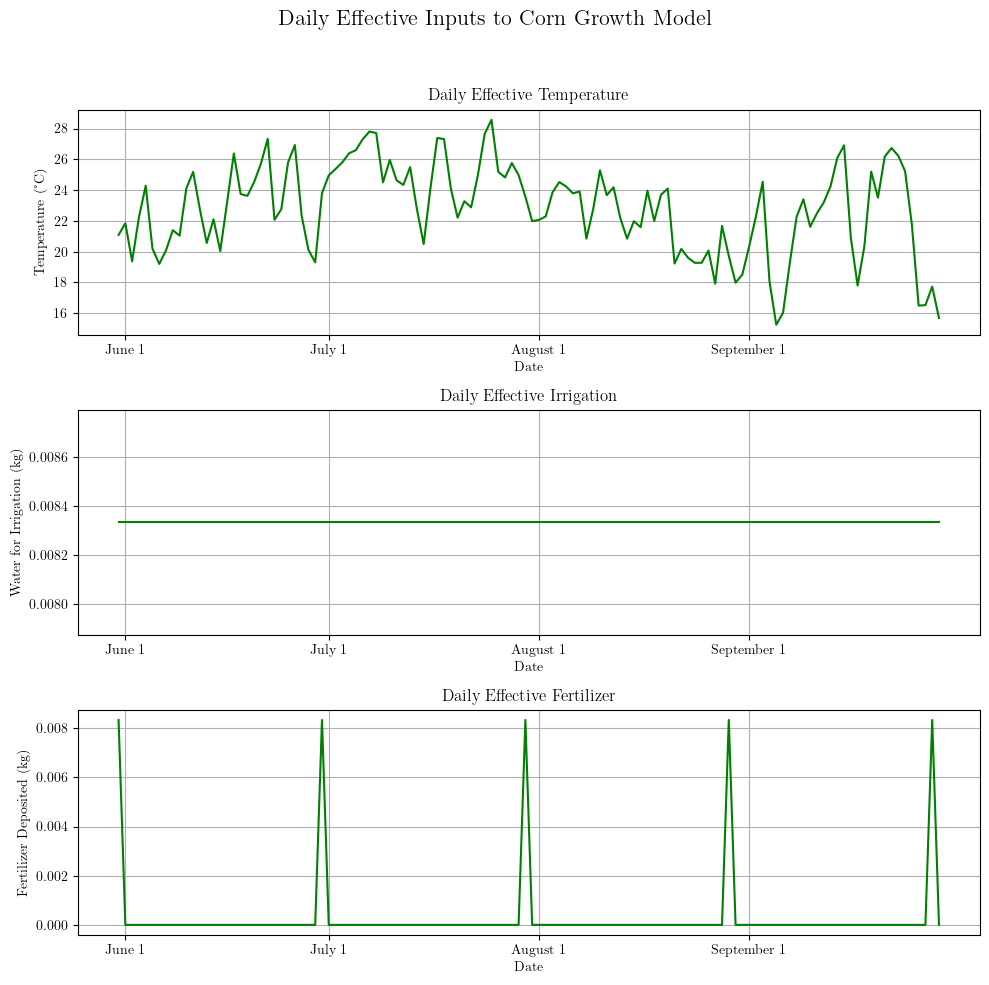

In [76]:
# Plot daily effective input data 
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
plot_consumption(consumption=effective_temperature, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[0],
                 title='Daily Effective Temperature', 
                 ylabel='Temperature (\N{DEGREE SIGN}C)')
plot_consumption(consumption=effective_irrigation, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[1],
                 title='Daily Effective Irrigation', 
                 ylabel='Water for Irrigation (kg)')
plot_consumption(consumption=effective_fertilizer, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[2],
                 title='Daily Effective Fertilizer', 
                 ylabel='Fertilizer Deposited (kg)')
daily_input_filename = f'{plots_output_directory}/{crop}_daily_inputs.png'
fig.suptitle(f'Daily Effective Inputs to {crop_for_title} Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent overlap
plt.savefig(daily_input_filename, format='png')
plt.show()

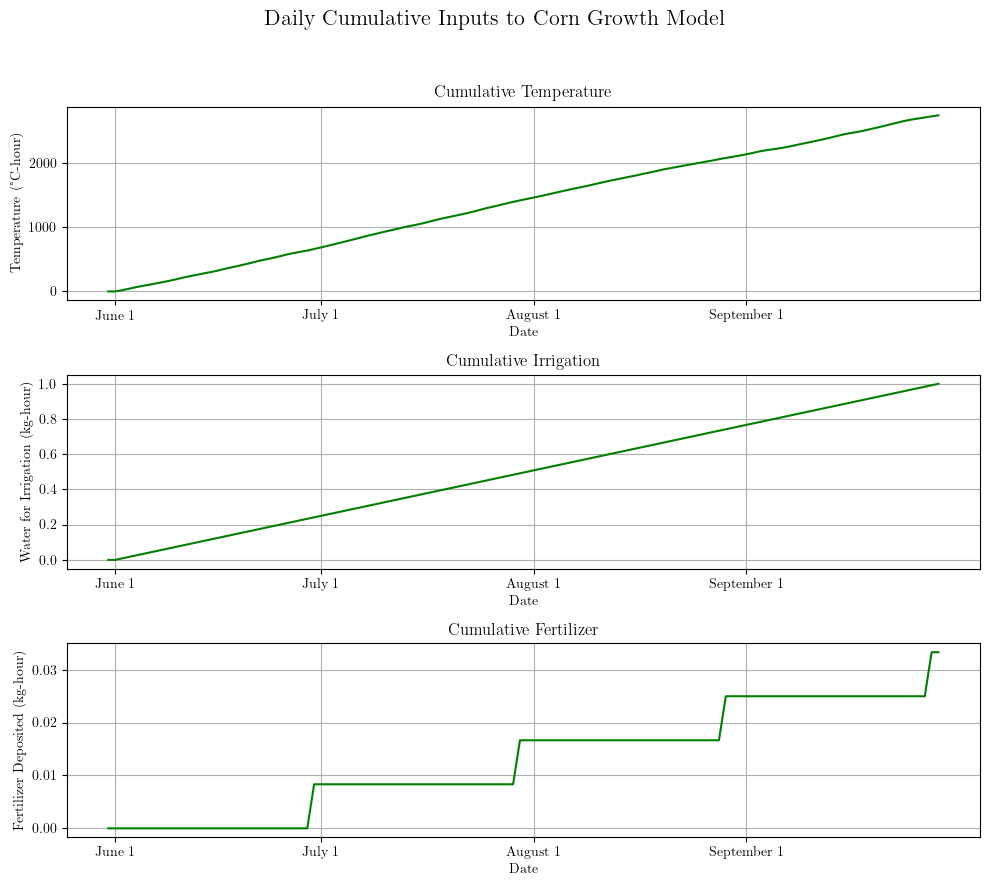

In [77]:
# Plot daily cumulative input data 
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
plot_consumption(consumption=cumulative_temperature, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[0],
                 title='Cumulative Temperature', 
                 ylabel='Temperature (\N{DEGREE SIGN}C-hour)')
plot_consumption(consumption=cumulative_irrigation, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[1],
                 title='Cumulative Irrigation', 
                 ylabel='Water for Irrigation (kg-hour)')
plot_consumption(consumption=cumulative_fertilizer, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[2],
                 title='Cumulative Fertilizer', 
                 ylabel='Fertilizer Deposited (kg-hour)')
daily_cum_filename = f'{plots_output_directory}/{crop}_daily_inputs.png'
fig.suptitle(f'Daily Cumulative Inputs to {crop_for_title} Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent overlap
plt.savefig(daily_cum_filename, format='png')
plt.show()

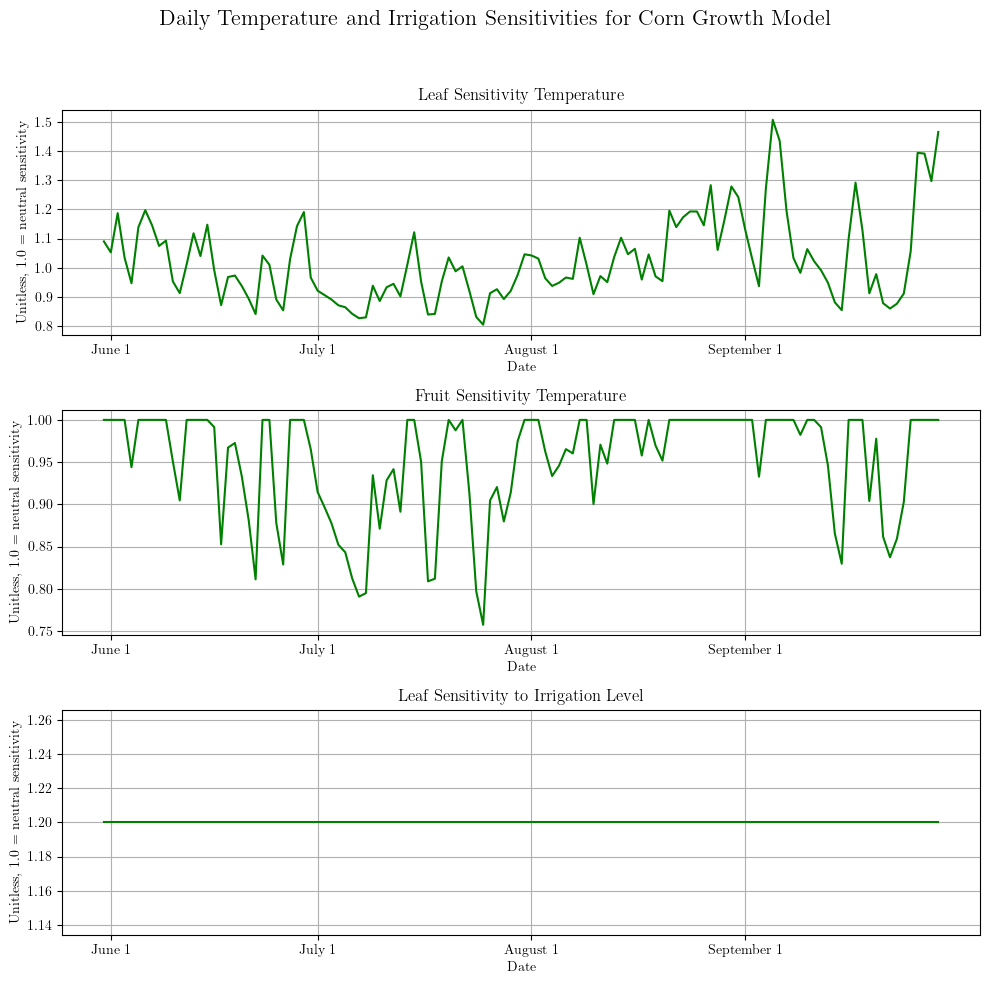

In [78]:
# Plot" sensitivity" input variables
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
plot_consumption(consumption=leaf_sensitivity_temp, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[0],
                 title='Leaf Sensitivity Temperature', 
                 ylabel='Unitless, 1.0 = neutral sensitivity')
plot_consumption(consumption=fruit_sensitivity_temp, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[1],
                 title='Fruit Sensitivity Temperature', 
                 ylabel='Unitless, 1.0 = neutral sensitivity')
plot_consumption(consumption=leaf_sensitivity_water, 
                 start_point=start_point, 
                 end_point=end_point, 
                 consumption_frequency='daily', 
                 ax=axs[2],
                 title='Leaf Sensitivity to Irrigation Level', 
                 ylabel='Unitless, 1.0 = neutral sensitivity')
sensitivities_filename = f'{plots_output_directory}/{crop}_sensitivities.png'
fig.suptitle(f'Daily Temperature and Irrigation Sensitivities for {crop_for_title} Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent overlap
plt.savefig(sensitivities_filename, format='png')
plt.show()

In [79]:
# Convert angles in degrees to radians
field_azimuth_angle = math.radians(field_azimuth_angle)
field_zenith_angle  = math.radians(field_zenith_angle) 
conal_angle_leaves_wrt_stem = math.radians(conal_angle_leaves_wrt_stem)

In [80]:
#----- MAIN SIMULATION -----#

# Set triggers
height_decay_triggered       = False
leaf_decay_triggered         = False
fruit_canopy_decay_triggered = False

# Begin simulation
todays_date = start_date
for day in range(total_simulation_days):

    # Print out the day
    print(f'Day {day+1} of {total_simulation_days}')

    # Update days after sowing and today's date
    days_after_sowing += 1
    todays_date += timedelta(days=1)

    # Loop over time steps (for updates that happen periodically throughout a single day)
    for time_step in range(num_time_steps_per_day):

        # Index for time-dependent variables
        t = day * num_time_steps_per_day + time_step
        if t == total_time_steps-1:
            break # cannot fill the t+1 position if this condition is true, so break the loop
    
        #print(f'Day {day} of {total_simulation_days} | time step {time_step} of {num_time_steps_per_day} | time step {t} of {total_time_steps}')

        # Update today's date to the hour
        todays_date += timedelta(hours=time_step_size)

        # Initialize an instance of the SolarPosition class based on latest time
        current_solar_position = SolarPosition(key_region_dict=key_region_dict, date_time=todays_date, region=region)

        '''TODO debug with NOAA formulas'''
        solar_azimuth_angle = math.radians(current_solar_position.get_solar_azimuth_angle()) # TODO, debug with NOAA formulas
        solar_zenith_angle  = math.radians(current_solar_position.get_solar_zenith_angle())  # TODO, debug with NOAA formulas
        print(f'(azimuth, zenith) = ({solar_azimuth_angle}, {solar_zenith_angle})')
        initial_rad         = hourly_radiation[t] 

        # Plant height update 
        dhdt = 0
        logistic_growth_term     = growth_rate_height * height[t] * (1 - height[t]/carrying_capacity_height)
        if effective_irrigation[day] == 0:
            gaussian_irrigation_term = 0
        else:
            gaussian_irrigation_term = gains_height_from_water * growth_rate_height_water_specific * effective_irrigation[day]\
                                        * np.exp(-((cumulative_irrigation[day] - scaling_factor_peak_height_growth_water_specific * effective_irrigation[day])/\
                                                    (scaling_factor_peak_growth_time_height_water_specific * effective_irrigation[day]))**2)
        if effective_fertilizer[day] == 0:
            gaussian_fertilizer_term = 0
        else:
            gaussian_fertilizer_term = gains_height_from_fertilizer * growth_rate_height_fertilizer_specific * effective_fertilizer[day]\
                                        * np.exp(-((cumulative_fertilizer[day] - scaling_factor_peak_height_growth_fertilizer_specific * effective_fertilizer[day])/\
                                                    (scaling_factor_peak_growth_time_height_fertilizer_specific * effective_fertilizer[day]))**2)
        decay_term               = -1 * decay_rate_height * height[t]
        if height[t] > carrying_capacity_height:
            height_decay_triggered = True
        if height_decay_triggered:   
            dhdt = logistic_growth_term + gaussian_irrigation_term + gaussian_fertilizer_term + decay_term
        else: 
            dhdt = logistic_growth_term + gaussian_irrigation_term + gaussian_fertilizer_term
        height[t+1] = height[t] + dhdt * time_step_size
        
        # Leaf area update 
        dAdt = 0
        if effective_temperature[day] == 0:
            gaussian_temperature_term = 0
        else: 
            gaussian_temperature_term = gains_leaf_area_from_temp * growth_rate_leaf_area_temp_specific * effective_temperature[day]\
                                        * np.exp(-((cumulative_temperature[day] - scaling_factor_peak_leaf_area_growth_temp_specific * effective_temperature[day])/\
                                                   (scaling_factor_peak_growth_time_leaf_area_temp_specific * effective_temperature[day]))**2)
        if effective_irrigation[day] == 0:
            gaussian_irrigation_term = 0
        else:
            gaussian_irrigation_term = gains_leaf_area_from_water * growth_rate_leaf_area_water_specific * effective_irrigation[day]\
                                       * np.exp(-((cumulative_irrigation[day] - scaling_factor_peak_leaf_area_growth_water_specific * effective_irrigation[day])/\
                                                  (scaling_factor_peak_growth_time_leaf_area_water_specific * effective_irrigation[day]))**2)
        if effective_fertilizer[day] == 0:
            gaussian_fertilizer_term = 0
        else:
            gaussian_fertilizer_term = gains_leaf_area_from_fertilizer * growth_rate_leaf_area_fertilizer_specific * effective_fertilizer[day]\
                                       * np.exp(-((cumulative_fertilizer[day] - scaling_factor_peak_leaf_area_growth_fertilizer_specific * effective_fertilizer[day])/\
                                                  (scaling_factor_peak_growth_time_leaf_area_fertilizer_specific * effective_fertilizer[day]))**2)
        temperature_decay_term = -1 * decay_rate_leaf_area_temp_specific * leaf_sensitivity_temp[day] * leaf_area[t]
        irrigation_decay_term = -1 * decay_rate_leaf_area_water_specific * leaf_sensitivity_water[day] * leaf_area[t]
        if leaf_area[t] > carrying_capacity_leaf_area:
            leaf_decay_triggered = True
        if height[t] > threshold_height_leaf_growth: # Seedling --> vegetative transition
            if leaf_decay_triggered:            
                dAdt = gaussian_temperature_term + gaussian_irrigation_term + gaussian_fertilizer_term + temperature_decay_term + irrigation_decay_term                    
            else:
                dAdt = gaussian_temperature_term + gaussian_irrigation_term + gaussian_fertilizer_term
        else:
            dAdt = 0
        leaf_area[t+1] = leaf_area[t] + dAdt * time_step_size

        # For each of the plants, determine how well light passes through the canopy
        # First, circumscribe squares about the circles that represents the canopies
        radius = np.sqrt(leaf_area[t]/np.pi)
        square_side_lengths = 2 * radius

        # Get the coordinates that define the center of the lower left plant (our representative plants)
        xcoord_canopy = coords_2d_plant_xy[0, 0]
        ycoord_canopy = coords_2d_plant_xy[0, 1]

        # Get the coordinates that define the lower left corners of the squares
        start_x_square = xcoord_canopy - radius
        start_y_square = ycoord_canopy - radius

        # Discretize the canopy of each plant - find how to discretize in x and y
        side_length_leaf_test_point = np.sqrt(area_leaf_test_point)
        num_test_points_x_per_plant = int(np.floor(square_side_lengths / side_length_leaf_test_point))
        num_test_points_y_per_plant = num_test_points_x_per_plant

        # Calculate the canopy density for each plant
        canopy_density = 0
        if leaf_area[t] != 0:
            canopy_density = 3 * canopy_biomass[t] / leaf_area[t] * np.sqrt(np.pi/leaf_area[t]) * math.tan(conal_angle_leaves_wrt_stem)
        else:
            canopy_density = 0

        conal_angle_leaves_wrt_origin = conal_angle_leaves_wrt_stem + field_zenith_angle

        # For the representative plant, tile the square that circumscribes the canopy       
        avg_irradiance_leaf_surface = initial_rad 
        for j in range(num_test_points_x_per_plant):
            x = start_x_square + j * side_length_leaf_test_point
            for k in range(num_test_points_y_per_plant):
                y = start_y_square + k * side_length_leaf_test_point

                # Only evaluate irradiance at test point if it is within the canopy
                r = np.sqrt(x**2 + y**2)
                if r <= radius:

                    # Calculate the azimuthal angle of the point
                    azimuth_angle_test_point_wrt_stem = math.tan(y/x) # radians
                    azimuth_angle_test_point_wrt_origin = azimuth_angle_test_point_wrt_stem + field_azimuth_angle
                    
                    # Calculated just in case, but unused for now
                    #radius_wrt_stem = np.sqrt(x**2 + y**2)
                    #z_wrt_height = radius_wrt_stem * 1/math.tan(conal_angle_leaves_wrt_stem)

                    # Calculate the extinction coefficient for this test_point
                    extinction_angle_photosynthesis = conal_angle_leaves_wrt_origin - solar_zenith_angle * math.cos(azimuth_angle_test_point_wrt_origin - solar_azimuth_angle)
                    extinction_coefficient_photosynthesis = math.sin(extinction_angle_photosynthesis)

                    # Calculate the irradiance at this test point
                    irradiance_test_point = initial_rad * (1 - np.exp(-extinction_coefficient_photosynthesis * canopy_density/typical_canopy_density))

                    # Update the average irradiance across this canopy
                    avg_irradiance_leaf_surface = (avg_irradiance_leaf_surface + irradiance_test_point)/2

        # Update the total irradiance at the leaf surface for the representative plant     
        irradiance_leaf_surface = avg_irradiance_leaf_surface
            
        # Canopy biomass update
        dcdt = 0
        if dAdt < threshold_dAdt_canopy_fruit_decay:
            fruit_canopy_decay_triggered = True
        if fruit_canopy_decay_triggered:           
            dcdt = efficiency_coefficient_photosynthesis * irradiance_leaf_surface * leaf_area[t]\
                   * (growth_rate_canopy_biomass * canopy_biomass[t]\
                      * (1 - canopy_biomass[t]/carrying_capacity_canopy_biomass)\
                      - decay_rate_canopy_biomass * canopy_biomass[t])
        else:
            dcdt = efficiency_coefficient_photosynthesis * irradiance_leaf_surface * leaf_area[t]\
                   * growth_rate_canopy_biomass * canopy_biomass[t]\
                   * (1 - canopy_biomass[t]/carrying_capacity_canopy_biomass)
        canopy_biomass[t+1] = canopy_biomass[t] + dcdt * time_step_size

        # Fruit biomass update
        # Vegetative --> flowering/fruiting transition (TODO review model)
        dPdt = 0
        if canopy_biomass[t] > threshold_canopy_fruit_growth:
            if fruit_canopy_decay_triggered:                          
                dPdt = growth_rate_fruit_biomass * fruit_sensitivity_temp[day]\
                       * canopy_biomass[t]/carrying_capacity_canopy_biomass\
                       * fruit_biomass[t] * (1 - fruit_biomass[t]/carrying_capacity_fruit_biomass)\
                       - decay_rate_fruit_biomass * fruit_biomass[t]
            else:
                dPdt = growth_rate_fruit_biomass * fruit_sensitivity_temp[day]\
                       * canopy_biomass[t]/carrying_capacity_canopy_biomass\
                       * fruit_biomass[t] * (1 - fruit_biomass[t]/carrying_capacity_fruit_biomass)
        else:
            dPdt = 0
        fruit_biomass[t+1] = fruit_biomass[t] + dPdt * time_step_size

Day 1 of 122
(azimuth, zenith) = (2.208539635473625, 0.050914625878635586)
(azimuth, zenith) = (2.208539635473625, 0.05483113556160755)
(azimuth, zenith) = (2.208539635473625, 0.058747645244579504)
(azimuth, zenith) = (2.208539635473625, 0.06266415492755148)
(azimuth, zenith) = (2.208539635473625, 0.06658066461052345)
(azimuth, zenith) = (2.208539635473625, 0.07049717429349542)
(azimuth, zenith) = (2.208539635473625, 0.07441368397646739)
(azimuth, zenith) = (2.208539635473625, 0.07833019365943936)
(azimuth, zenith) = (2.208539635473625, 0.08224670334241131)
(azimuth, zenith) = (2.208539635473625, 0.08616321302538327)
(azimuth, zenith) = (2.208539635473625, 0.09007972270835525)
(azimuth, zenith) = (2.208539635473625, 0.0)
(azimuth, zenith) = (2.208539635473625, 0.0039165096829719675)
(azimuth, zenith) = (2.208539635473625, 0.007833019365943935)
(azimuth, zenith) = (2.208539635473625, 0.011749529048915902)
(azimuth, zenith) = (2.208539635473625, 0.01566603873188787)
(azimuth, zenith) = (

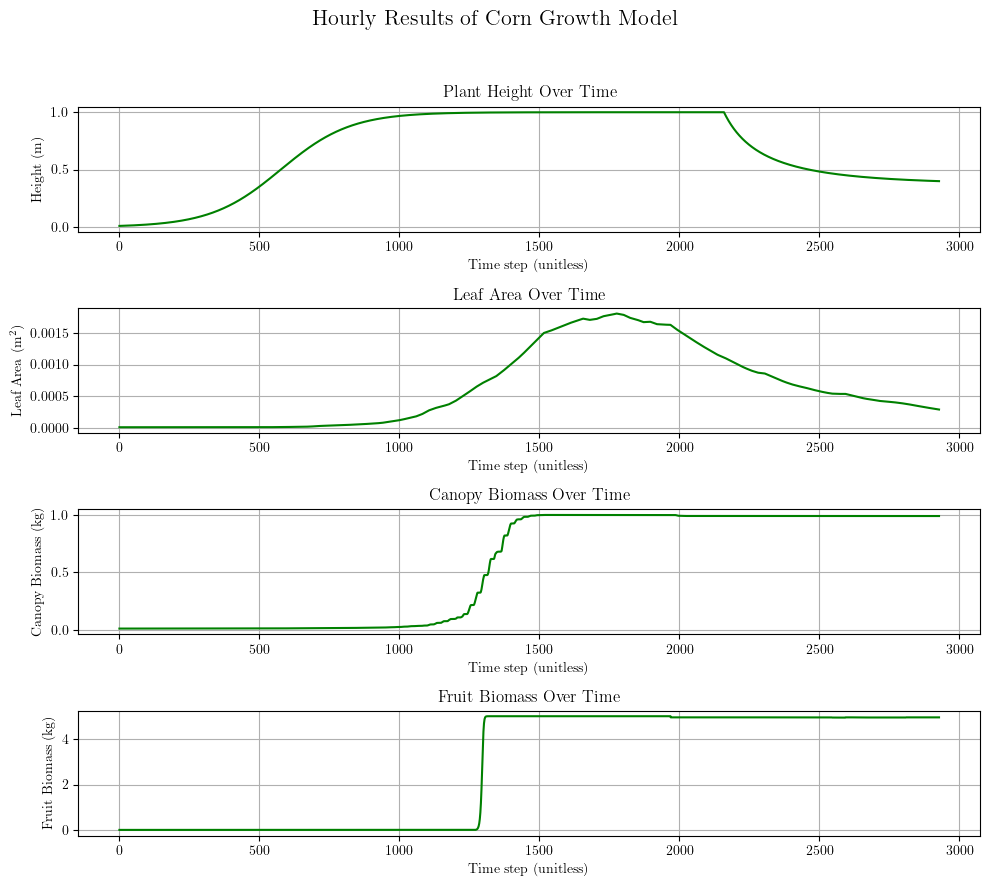

In [81]:
# Plot the time-dependent variables
#date_labels_points, date_labels_labels = get_hourly_data_labels(start_point, end_point)

fig, axs = plt.subplots(4, 1, figsize=(10, 9))

# Height
axs[0].plot(np.arange(total_time_steps), height, color='green')
axs[0].set_xlabel('Time step (unitless)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title(f'Plant Height Over Time')
#axs[0].set_xticks(ticks=date_labels_points) # Fix
#axs[0].set_xticklabels(labels=date_labels_labels, rotation=0) # Fix
axs[0].grid(True)

# Leaf Area
axs[1].plot(np.arange(total_time_steps), leaf_area, color='green')
axs[1].set_xlabel('Time step (unitless)')
axs[1].set_ylabel(r'Leaf Area (m$^{2}$)')
axs[1].set_title(f'Leaf Area Over Time')
#axs[1].set_xticks(ticks=date_labels_points) # Fix
#axs[1].set_xticklabels(labels=date_labels_labels, rotation=0) # Fix
axs[1].grid(True)

# Canopy Biomass
axs[2].plot(np.arange(total_time_steps), canopy_biomass, color='green')
axs[2].set_xlabel('Time step (unitless)')
axs[2].set_ylabel('Canopy Biomass (kg)')
axs[2].set_title(f'Canopy Biomass Over Time')
#axs[2].set_xticks(ticks=date_labels_points) # Fix
#axs[2].set_xticklabels(labels=date_labels_labels, rotation=0) # Fix
axs[2].grid(True)

# Fruit Biomass
axs[3].plot(np.arange(total_time_steps), fruit_biomass, color='green')
axs[3].set_xlabel('Time step (unitless)')
axs[3].set_ylabel('Fruit Biomass (kg)')
axs[3].set_title(f'Fruit Biomass Over Time')
#axs[3].set_xticks(ticks=date_labels_points) # Fix
#axs[3].set_xticklabels(labels=date_labels_labels, rotation=0) # Fix
axs[3].grid(True)

sim_results_filename = f'{plots_output_directory}/{crop}_sim_results.png'
fig.suptitle(f'Hourly Results of {crop_for_title} Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent overlap
plt.savefig(sim_results_filename, format='png')
plt.show()

In [82]:
# Export hourly results to CSV for visualization with other software
hourly_output_data = np.hstack((height.reshape(-1, 1), leaf_area.reshape(-1, 1), canopy_biomass.reshape(-1, 1), fruit_biomass.reshape(-1, 1)))
headers = ['Plant Height (m)', 'Leaf Area (m2)', 'Canopy Biomass (kg)', 'Fruit Biomass (kg)']
df = pd.DataFrame(hourly_output_data, columns=headers)
df.to_csv(f'{csv_output_directory}/{crop}_growth_results_single_plant_hourly.csv', index=False)

In [83]:
# Export daily results to CSV for visualization with other software
daily_output_data = np.hstack((height[::HOURS_PER_DAY].reshape(-1, 1), 
                               leaf_area[::HOURS_PER_DAY].reshape(-1, 1),
                               canopy_biomass[::HOURS_PER_DAY].reshape(-1, 1),
                               fruit_biomass[::HOURS_PER_DAY].reshape(-1, 1)))
headers = ['Plant Height (m)', 'Leaf Area (m2)', 'Canopy Biomass (kg)', 'Fruit Biomass (kg)']
df = pd.DataFrame(daily_output_data, columns=headers)
df.to_csv(f'{csv_output_directory}/{crop}_growth_results_single_plant_daily.csv', index=False)

In [84]:
# Set inputs for 3D visualization
mpl.rcParams['animation.writer'] = 'ffmpeg'

# Set plant styles
stem_color                   = key_crop_styles_dict[crop]["stem_color"]
canopy_colormap_name         = key_crop_styles_dict[crop]["canopy_colormap_name"]
fruit_color                  = key_crop_styles_dict[crop]["fruit_color"]
num_leaves_per_canopy        = key_crop_styles_dict[crop]["num_leaves_per_canopy"]
num_fruits_per_canopy        = key_crop_styles_dict[crop]["num_fruits_per_canopy"]
list_of_fruit_azim_angles    = key_crop_styles_dict[crop]["list_of_fruit_azim_angles"]
fruit_to_canopy_radius_ratio = key_crop_styles_dict[crop]["fruit_to_canopy_radius_ratio"]

# Normalize the canopy biomass for color mapping (0.0 to 1.0)
norm_canopy_biomass = Normalize()(canopy_biomass)
canopy_colormap = getattr(plt.cm, canopy_colormap_name)
canopy_color = canopy_colormap(norm_canopy_biomass)

# Get the radii of the spheres that represent the leaves
canopy_radii = np.sqrt(leaf_area/(4 * np.pi)) * num_leaves_per_canopy 

# Set the stem/trunk radius 
stem_aspect_ratio = 1/12
stem_radius = stem_aspect_ratio * np.max(height)

# Define helper function for fruit ppsitions
def generate_fruit_positions(num_fruits_per_canopy, rfruit, list_of_fruit_azim_angles):

    # Create the theta array with evenly spaced values from 0 to 2*pi
    fruit_theta = np.linspace(0, 2*np.pi, num=num_fruits_per_canopy, endpoint=False)
    
    # Create the fruit_phi array with alternating values of pi/4 and 3*pi/4
    fruit_phi = np.zeros(num_fruits_per_canopy)
    for i in range(num_fruits_per_canopy):
        fruit_phi_idx = i % len(list_of_fruit_azim_angles)
        fruit_phi[i] = list_of_fruit_azim_angles[fruit_phi_idx]
    
    # Convert to Cartesian coordinates
    x_fruit_centers = rfruit * np.sin(fruit_phi) * np.cos(fruit_theta)
    y_fruit_centers = rfruit * np.sin(fruit_phi) * np.sin(fruit_theta)
    z_fruit_centers = rfruit * np.cos(fruit_phi)

    return x_fruit_centers, y_fruit_centers, z_fruit_centers

In [85]:
# Make a 3D video of a single crop growing
if make_video:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sm = plt.cm.ScalarMappable(cmap=canopy_colormap, norm=Normalize(vmin=0, vmax=1))
    sm.set_array([])
    elev = 23
    azim = 45

    def update(frame):
        ax.clear()
        t = int(frame * DAYS_PER_FRAME * HOURS_PER_DAY) # only update the plot daily
        print(f'Frame {frame} of {int(total_simulation_days/DAYS_PER_FRAME)}')
        
        # Draw the stem as a brown cylinder
        zstem = np.linspace(0, height[t], 100)
        theta = np.linspace(0, 2 * np.pi, 100)
        theta, zstem = np.meshgrid(theta, zstem)
        xstem = stem_radius * np.cos(theta)
        ystem = stem_radius * np.sin(theta)
        
        ax.plot_surface(xstem, ystem, zstem, color=stem_color, alpha=0.5, linewidth=0, antialiased=False)

        # Draw the end caps of the cylinder that represents the stem
        zstem_bottom = np.zeros_like(xstem)
        zstem_top = np.full_like(xstem, height[t])
        
        ax.plot_surface(xstem.reshape(-1, 1), ystem.reshape(-1, 1), zstem_bottom.reshape(-1, 1), color=stem_color, alpha=0.5, linewidth=0, antialiased=False)
        ax.plot_surface(xstem.reshape(-1, 1), ystem.reshape(-1, 1), zstem_top.reshape(-1, 1),    color=stem_color, alpha=0.5, linewidth=0, antialiased=False)
        
        # Draw the canopy as a sphere on top of the stem
        theta = np.linspace(0, 2 * np.pi, 100)
        phi = np.linspace(0, np.pi, 100)
        theta, phi = np.meshgrid(theta, phi)
        xcanopy = canopy_radii[t] * np.sin(phi) * np.cos(theta)
        ycanopy = canopy_radii[t] * np.sin(phi) * np.sin(theta)
        zcanopy = height[t] + canopy_radii[t] * np.cos(phi)  # Position sphere at top of cylinder
        
        ax.plot_surface(xcanopy, ycanopy, zcanopy, color=canopy_color[t], alpha=0.5, linewidth=0, antialiased=False)

        # Define the fruit radius (smaller than the canopy radius)
        fruit_radius = canopy_radii[t] * fruit_to_canopy_radius_ratio

        # Draw fruit as a small sphere on the outside of the canopy
        rfruit = canopy_radii[t]
        x_fruit_centers, y_fruit_centers, z_fruit_centers = generate_fruit_positions(num_fruits_per_canopy, rfruit, list_of_fruit_azim_angles)

        # Draw the fruit sphere(s)
        theta = np.linspace(0, 2 * np.pi, 50)
        phi = np.linspace(0, np.pi, 50)
        theta, phi = np.meshgrid(theta, phi)
        for fruit in range(num_fruits_per_canopy):
            x_fruit_center = x_fruit_centers[fruit]
            y_fruit_center = y_fruit_centers[fruit]
            z_fruit_center = z_fruit_centers[fruit]

            xfruit = fruit_radius * np.sin(phi) * np.cos(theta) + x_fruit_center
            yfruit = fruit_radius * np.sin(phi) * np.sin(theta) + y_fruit_center
            zfruit = fruit_radius * np.cos(phi) + z_fruit_center + height[t]

            ax.plot_surface(xfruit, yfruit, zfruit, color=fruit_color, alpha=1.0, linewidth=0, antialiased=True)
        
        # Set the plot limits
        ax.set_xlim(-3 * np.max(canopy_radii), 3 * np.max(canopy_radii))
        ax.set_ylim(-3 * np.max(canopy_radii), 3 * np.max(canopy_radii))
        ax.set_zlim(0, height[-1] + 2 * np.max(canopy_radii) + 1)
        ax.set_aspect('auto')
        
        # Set the axis labels and title
        ax.set_xlabel(r'$x$ (m)')
        ax.set_ylabel(r'$y$ (m)')
        ax.set_zlabel('Height (m)')
        ax.set_title(f'Growth Cycle of a Representative {crop_for_title} Plant')

        # Set the camera angle 
        ax.view_init(elev=elev, azim=azim)

    # Add colorbar for the density of the canopy
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('Canopy Biomass (kg)')

    # Create the animation
    ani = FuncAnimation(fig, update, frames=int(total_simulation_days/DAYS_PER_FRAME), repeat=False)

    # Save the animation as a movie file
    ani.save(f'{video_output_directory}/{crop}_growth_elev{elev}_azim{azim}.mp4', writer='ffmpeg', fps=10)

    # Show the plot
    plt.show()

In [86]:
# Genetic Algorithm Search Bounds
irrgation_amount_min  = 0     # kg
irrgation_amount_max  = 180   # kg
irrigation_period_min = 0.333 # once every 0.333 days
irrigation_period_max = 150   # once every 150 days

fertilizer_amount_min = 0     # kg
fertilizer_amount_max = 180   # kg
fertilizer_period_min = 0.333 # once every 0.333 days
fertilizer_period_max = 150   # once every 150 days

# Assemble Search Bound Vectors
lower_bounds = np.array([irrgation_amount_min, irrigation_period_min, fertilizer_amount_min, fertilizer_period_min])
upper_bounds = np.array([irrgation_amount_max, irrigation_period_max, fertilizer_amount_max, fertilizer_period_max])

In [87]:
# Genetic Algorithm Parameters
P = 10   # number of design strings to breed
K = 10   # number of offspring design strings 
G = 5000 # maximum number of generations
S = 200  # total number of design strings per generation
dv = 4  # number of design variables per string

In [88]:
# Genetic Algorithm Helper Function
def sort(pi):
    new_pi = np.sort(pi, axis=0)
    ind = np.argsort(pi, axis=0)
    return [new_pi, ind]

def reorder(Lambda, ind):
    temp = np.zeros((S,dv))
    for i in range(0, len(ind)):
        temp[i,:] = Lambda[int(ind[i]),:]
    Lambda = temp
    return Lambda

def get_unique_designs(Lambda, costs):

    # Costs are often equal to >10 decimal points
    # Truncate to obtain a richer set of suggestions
    new_costs = np.round(costs, decimals=3)
    
    # Obtain Unique Strings and Costs
    [unique_costs, iuniq] = np.unique(new_costs, return_index=True)
    unique_strings = Lambda[iuniq]

    return [unique_strings, unique_costs] 

In [89]:
# Cost Function Definition

def Pi(Lambda):

    irrgation_amount, irrigation_period, fertilizer_amount, fertilizer_period = [float(elem) for elem in Lambda]


In [90]:
# Apply a genetic algorithm to find the optimal irrigation and fertilizer amounts and frequencies
def GA():
    
    # Initialize arrays to store the cost and original indices of each generation
    PI = np.ones((G, S))
    Orig = np.ones((G, S))
    
    # Initialize arrays to store best performer and parent avg 
    Pi_min = np.zeros(G)     # best cost
    Pi_par_avg = np.zeros(G) # avg cost of parents
    
    # Generation counter
    g = 0

    # Initialize array to store costs for current generation
    cost = np.zeros(S)

    # Randomly populate first generation  
    Lambda = np.ones((S, dv))
    for i in range (S):
        Lambda[i, :] = np.random.uniform(lower_bounds, upper_bounds)
        cost[i] = Pi(Lambda[i, :])
            
    # Sort the costs of the first generation
    [new_cost, ind] = sort(cost)  
    PI[g, :] = new_cost.reshape(1,S) 
    
    # Store the cost of the best performer and average cost of the parents 
    Pi_min[g] = np.min(new_cost)
    Pi_par_avg[g] = np.mean(new_cost[0:P])
    
    # Update Lambda based on sorted indices
    Lambda = reorder(Lambda, ind)
    Orig[g,:] = ind.reshape(1,S) 
    
    # Perform all later generations    
    while g < G:
        
        print(g)
        cost[0:P] = new_cost[0:P] # retain the parents from the previous generation
        
        # Select top parents P from Lambda to be breeders
        for p in range(0, P, 2):
            phi1, phi2 = np.random.rand(2)
            kid1 = phi1*Lambda[p, :] + (1-phi1)*Lambda[p+1, :]
            kid2 = phi2*Lambda[p, :] + (1-phi2)*Lambda[p+1, :]
            
            # Append offspring to Lambda 
            Lambda[P+p,   :] = kid1
            Lambda[P+p+1, :] = kid2
        
            # Evaluate Offspring
            cost[P+p]   = Pi(Lambda[P+p, :])
            cost[P+p+1] = Pi(Lambda[P+p+1, :])
                     
        # Randomly generate new design strings to fill th rest of the population
        for i in range(S-P-K):
            Lambda[P+K+i, :] = np.random.uniform(lower_bounds, upper_bounds)
            cost[P+K+i] = Pi(Lambda[P+K+i, :])

        # Sort the costs for the gth generation
        [new_cost, ind] = sort(cost)  
        PI[g, :] = new_cost.reshape(1,S) 
    
        # Store the cost of the best performer and average cost of the parents 
        Pi_min[g] = np.min(new_cost)
        Pi_par_avg[g] = np.mean(new_cost[0:P])
    
        # Update Lambda based on sorted indices
        Lambda = reorder(Lambda, ind)
        Orig[g,:] = ind.reshape(1,S)  

        # Update the generation counter
        g = g + 1          
    
    return PI, Lambda, Orig, Pi_min, Pi_par_avg         